In [10]:
# Import Dependendies 
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import S&P500 Data using yfinance library
sp500 = yf.Ticker("^GSPC") 
hist = sp500.history(period="2y", interval="1mo")

# Read in covid twitter data from Kagle 
twitter_feb = pd.read_csv("emotionGroupsFeb.csv")
twitter_mar = pd.read_csv("emotionGroupsMarch.csv")
twitter_apr = pd.read_csv("emotionGroupsApril.csv")
twitter_may = pd.read_csv("emotionGroupsMay.csv")
twitter_jun = pd.read_csv("emotionGroupsJune.csv")

In [3]:
# DataFrame manipulations S&P500

# Change Date Format to Month-Name format
hist['Month'] = 0
for i in range(len(hist)):
    hist['Month'][i] = hist.index[i].month

hist = hist.reset_index()
for i in range(len(hist)):
    month_number = str(hist['Month'][i])
    datetime_object = dt.datetime.strptime(month_number, "%m")
    month_name = datetime_object.strftime("%B")
    hist['Month'][i] = month_name
hist = hist.set_index('Month')

# Slice data for Jan 20 through Jun 20
hist_2020 = hist.iloc[8:14]

# Calculate the percent change of the S&P500 for Jan 20 through Jun 20
hist_2020 = hist_2020[['Close']].pct_change().dropna()

hist_2020 = hist_2020[['Close']]
hist_2020.columns = ['Percent Change']


In [4]:
# DataFrame manipulations Covid Data
twitter_df = pd.concat([twitter_feb, twitter_mar, twitter_apr, twitter_may, twitter_jun], axis=0, join='outer')
twitter_df.dropna(inplace=True)
twitter_df.drop(['country', 'alpha-3', 'Unnamed: 0', 'country-code', 'name', 'Source'],axis=1, inplace=True)
twitter_df.reset_index().set_index('date', inplace=True)

# Cleaining Data and Filtering by Country
twitter_us = twitter_df.loc[twitter_df['Country']=='United States']
twitter_us.drop(['Country', 'Users (in million)', 'Total Tweets'], axis=1, inplace=True)
twitter_us = twitter_us.rename(columns={'date':'Month'})

In [5]:
# Merging the SP500 and Covid Emotion dataframes 
hist_2020 = hist_2020.reset_index()
Covid_SP500 = twitter_us.merge(hist_2020, on='Month')

In [6]:
# Define Panel Visualization Functions

def sunburst():
    """Emotional status during the height of Coronavirus."""
    
    sunburst_plot = px.sunburst(twitter_us, path=['Month', 'emotion_str'],
                  color='tweet',
                  color_continuous_scale='reds')
    return sunburst_plot

def Covid_SP500_line():
    """Emotional twitter effect on S&P500."""
    

    Covid_SP500_line_plot = Covid_SP500.hvplot(x='Month',
                                y='Percent Change', 
                                ylabel='Percent Change', 
                                groupby='emotion_str')
    return Covid_SP500_line_plot

def covid_sp500_heat_worry():
    """Correlation b/w volume of worry tweets and S&P500 returns during the height of Coronavirus."""
    
    # Filter dataframe by emotion and set the index to the Month Column
    Covid_SP500_worry = Covid_SP500.loc[Covid_SP500['emotion_str']=='worry']
    Covid_SP500_worry.set_index(['Month'], inplace=True)
    
    # Drop unrelated data and find correlation
    Covid_SP500_worry_map = Covid_SP500_worry.drop('tweetpm', axis=1)
    Covid_SP500_worry_map_corr = Covid_SP500_worry_map.corr()
    
    worry_corr_fig = plt.figure()   
    corr_heatmap_worry = sns.heatmap(Covid_SP500_worry_map_corr, vmin=-1, vmax=1)   
    plt.title('Worry')
    plt.close(worry_corr_fig)
    
    return pn.pane.Matplotlib(worry_corr_fig)

def covid_sp500_heat_hate():
    """Correlation b/w volume of hate tweets and S&P500 returns during the height of Coronavirus."""
    
    # Filter dataframe by emotion and set the index to the Month Column
    Covid_SP500_hate = Covid_SP500.loc[Covid_SP500['emotion_str']=='hate']
    Covid_SP500_hate.set_index(['Month'], inplace=True)
    
    # Drop unrelated data and find correlation
    Covid_SP500_hate_map = Covid_SP500_hate.drop('tweetpm', axis=1)
    Covid_SP500_hate_map_corr = Covid_SP500_hate_map.corr()
    
    hate_corr_fig = plt.figure()   
    corr_heatmap_hate = sns.heatmap(Covid_SP500_hate_map_corr, vmin=-1, vmax=1)   
    plt.title('Hate')
    plt.close(hate_corr_fig)
    
    return pn.pane.Matplotlib(hate_corr_fig)

def covid_sp500_heat_boredom():
    """Correlation b/w volume of boredom tweets and S&P500 returns during the height of Coronavirus."""
    
    # Filter dataframe by emotion and set the index to the Month Column
    Covid_SP500_boredom = Covid_SP500.loc[Covid_SP500['emotion_str']=='boredom']
    Covid_SP500_boredom.set_index(['Month'], inplace=True)
   
    # Drop unrelated data and find correlation
    Covid_SP500_boredom_map = Covid_SP500_boredom.drop('tweetpm', axis=1)
    Covid_SP500_boredom_map_corr = Covid_SP500_boredom_map.corr()
    
    boredom_corr_fig = plt.figure()   
    corr_heatmap_boredom = sns.heatmap(Covid_SP500_boredom_map_corr, vmin=-1, vmax=1)   
    plt.title('Boredom')
    plt.close(boredom_corr_fig)
    
    return pn.pane.Matplotlib(boredom_corr_fig)
    
    
def parallel_categories_Feb():
    """Qualatative relationship b/w monthly (Feb) volume of tweets and S&P500 returns."""
    
    # Filter dataframe by month
    Covid_SP500_Feb = Covid_SP500.loc[Covid_SP500['Month'] == 'February']
    Covid_SP500_Feb = Covid_SP500_Feb.round(decimals=2)
    
    
    parallel_cat_plot_Feb = px.parallel_categories(Covid_SP500_Feb, 
                           dimensions=['emotion_str','tweetpm', 'tweet', 'Percent Change'],
                           color="tweet", title='February', color_continuous_scale=px.colors.sequential.ice)
    return parallel_cat_plot_Feb

def parallel_categories_March():
    """Qualatative relationship b/w monthly (March) volume of tweets and S&P500 returns."""
    
    # Filter dataframe by month
    Covid_SP500_March = Covid_SP500.loc[Covid_SP500['Month'] == 'March']
    Covid_SP500_March = Covid_SP500_March.round(decimals=2)
    
    
    parallel_cat_plot_March = px.parallel_categories(Covid_SP500_March, 
                           dimensions=['emotion_str','tweetpm', 'tweet', 'Percent Change'],
                           color="tweet", title='March', color_continuous_scale=px.colors.sequential.ice)
    return parallel_cat_plot_March

def parallel_categories_Apr():
    """Qualatative relationship b/w monthly (April) volume of tweets and S&P500 returns."""

    # Filter dataframe by month
    Covid_SP500_Apr = Covid_SP500.loc[Covid_SP500['Month'] == 'April']
    Covid_SP500_Apr = Covid_SP500_Apr.round(decimals=2)
    
    
    parallel_cat_plot_Apr = px.parallel_categories(Covid_SP500_Apr, 
                           dimensions=['emotion_str','tweetpm', 'tweet', 'Percent Change'],
                           color="tweet", title='April', color_continuous_scale=px.colors.sequential.ice)
    return parallel_cat_plot_Apr

def parallel_categories_May():
    """Qualatative relationship b/w monthly (May) volume of tweets and S&P500 returns."""
    
    # Filter dataframe by month
    Covid_SP500_May = Covid_SP500.loc[Covid_SP500['Month'] == 'April']
    Covid_SP500_May = Covid_SP500_May.round(decimals=2)
    
    
    parallel_cat_plot_May = px.parallel_categories(Covid_SP500_May, 
                           dimensions=['emotion_str','tweetpm', 'tweet', 'Percent Change'],
                           color="tweet", title='May', color_continuous_scale=px.colors.sequential.ice)
    return parallel_cat_plot_May

def parallel_categories_June():
    """Qualatative relationship b/w monthly (June) volume of tweets and S&P500 returns."""
    
    # Filter dataframe by month
    Covid_SP500_June = Covid_SP500.loc[Covid_SP500['Month'] == 'June']
    Covid_SP500_June = Covid_SP500_June.round(decimals=2)
    
    
    parallel_cat_plot_June = px.parallel_categories(Covid_SP500_June, 
                           dimensions=['emotion_str','tweetpm', 'tweet', 'Percent Change'],
                           color="tweet",title='June',color_continuous_scale=px.colors.sequential.ice)
    return parallel_cat_plot_June
                                          
def sp500_covid_bar():
    """Comparison b/w volume of tweets per emotion and S&P500 returns during the height of Coronavirus."""
    
    # Filter dataframe by month and add closing prices to dataframe
    sp500_close = hist[['Close']].iloc[8:14]
    Covid_SP500_close = sp500_close.merge(Covid_SP500, on='Month')

    sp500_covid_bar_plot = Covid_SP500_close.hvplot.bar(x='Month', 
                             y=['tweet', 'Close'], 
                             xlabel = 'Month', 
                             ylabel ='tweet',
                             groupby='emotion_str',
                             title='SP500 vs Covid', 
                             height=400,
                             rot=90)        
    return sp500_covid_bar_plot    


def scatter_plot_():
    """Emotional Relationship b/w volume of tweet and S&P500 returns during the height of Coronavirus."""
    
    # Filter dataframe by month and add closing prices to dataframe
    sp500_close = hist[['Close']].iloc[8:14]
    Covid_SP500_close = sp500_close.merge(Covid_SP500, on='Month')
    
    covid_sp500_scatter = Covid_SP500_close.hvplot.scatter(x='tweet', 
                                                           y='Percent Change',
                                                           groupby='emotion_str')                                                     
    return covid_sp500_scatter
    

In [7]:
title = pn.pane.Markdown(
    """
    # Emotional Responses to Covid and its Relationship with the S&P500
    """,
    width=800,
)

welcome = pn.pane.Markdown(
    """
    This dashboard was created with the intent of giving a visual represantion of the possible relationship between Emotional Response
    as fueled by social media and its potential impact on the stock market. 
    """
)
tabs = pn.Tabs(("Welcome", pn.Column(welcome, sp500_covid_bar())),
               ("Monthy Analysis Tweets", pn.Column(sunburst())),
               ("Correlations Between the SP500 and Covid Tweets ", pn.Row(covid_sp500_heat_hate(), covid_sp500_heat_worry(), covid_sp500_heat_boredom())),
               ("Scattermaps to show Relations", pn.Row(scatter_plot_())),
              ("Tweets by Emotion", pn.Row(parallel_categories_Feb(), parallel_categories_March(),parallel_categories_Apr(), parallel_categories_May(), parallel_categories_June())),
              ("Comparison Between SP500 Covid Tweets ", pn.Column(sp500_covid_bar(), Covid_SP500_line())))
            

In [8]:
# Create the dashboard
panel = pn.Column(pn.Row(title),tabs, width=500)

Column(width=500)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='emotion_str', options=['anger', 'boredom', ...], value='anger', width=250)
                    [1] VSpacer()
        [1] Column
            [0] Plotly(Figure)
        [2] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Row
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='emotion_str', options=['anger', 'boredom', ...], value='anger', width=250)
                    [1] VSpacer()
        [4] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
            [2] Plotly(Figure)
            [3] Plotly(Figure)
            [4] Plotly(Figure)
        [5] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='emotion_str', options=['anger', 'boredom', ...], value='anger', width=250)
                    [1] VSpacer()
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='emotion_str', options=['anger', 'boredom', ...], value='anger', width=250)
                    [1] VSpacer()
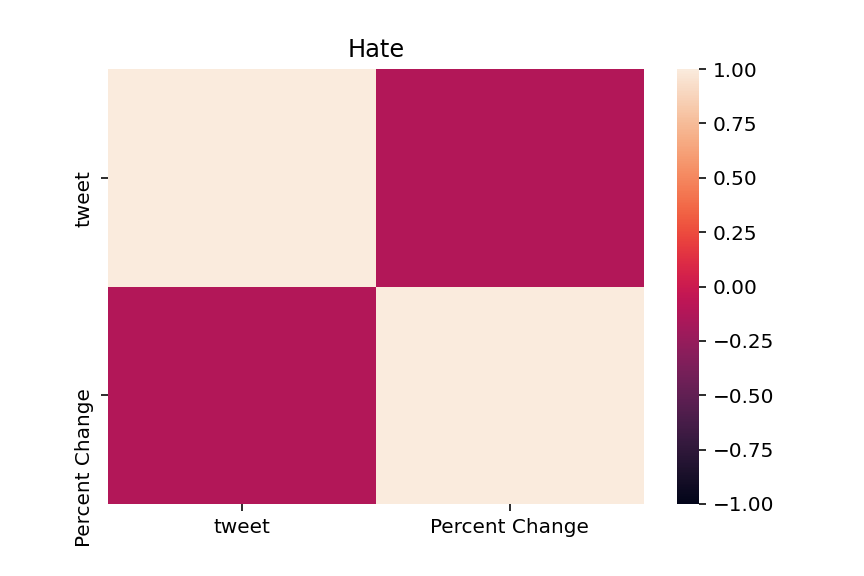
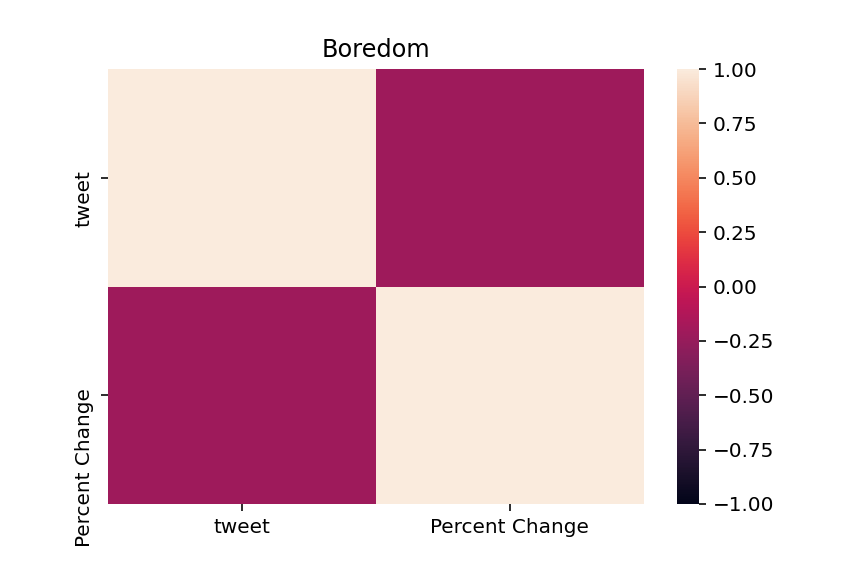
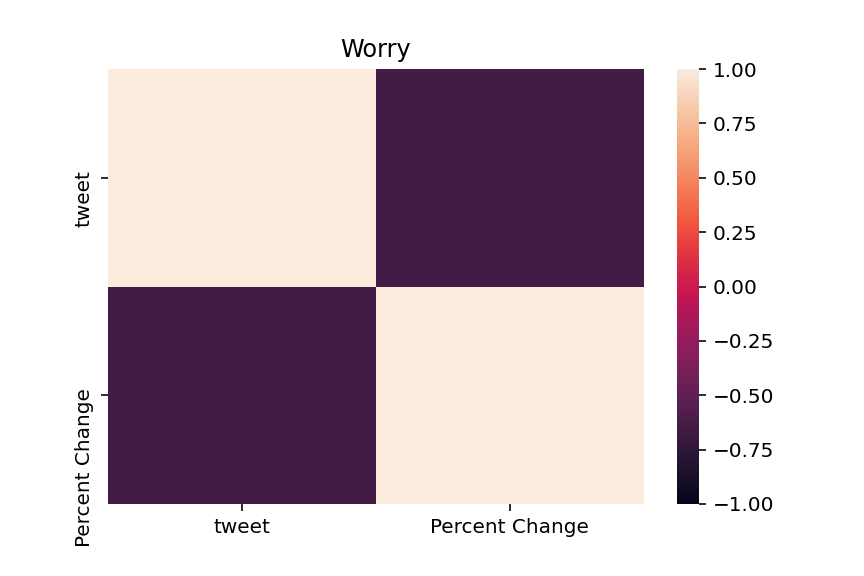

In [9]:
# Serve the dashboard
panel.servable()